# Lasso Safe Screening for Feature Elimination

Lasso promotes sparsity in machine learning, statistics, and signal processing but can be computationally expensive. Safe screening mitigates this by identifying zero coefficients early, reducing memory and computation. This post explores its mathematical foundation and compares two state-of-the-art techniques: GAP and RYU ball screening.

## 1. Lasso Problem and safe screening

### Lasso problem

Given a feature matrix $ A \in \mathbb{R}^{m \times n} $ and a response vector $ b \in \mathbb{R}^m $, the **Lasso problem** is  

$$
\min_{x \in \mathbb{R}^n} \frac{1}{2} \|b -Ax\|_2^2 + \lambda \|x\|_1
$$

where $ \lambda > 0 $ controls sparsity. Large $ \lambda $ encourages more zero entries in $ x $.  

### Dual Problem  

The **dual problem** of Lasso with variable $ u \in \mathbb{R}^m $:  

$$
\max_{u \in \mathbb{R}^m} \frac{1}{2} \|b\|_2^2 - \frac{1}{2} \|b - u\|_2^2
$$

subject to the constraint:

$$
\|A^T u\|_\infty \leq \lambda
$$

Note that for some given $x$, we can construct a feasible dual variable $u$ using Dual Scaling 

$$
    u_x = \frac{\lambda}{\|A(b- A x)\|_\infty} (b- Ax)
$$

Note that $u_x$ satisfies
$$
    x\rightarrow x^\star \Longrightarrow u_x \rightarrow u^\star.
$$
where $x^\star$ and $u^\star$ be any optimal solution of Lasso and its dual problem, and that the convergence of Dual Gap holds
$$
    x\rightarrow x^\star \Longrightarrow  \text{gap}(x, u_x) \rightarrow 0.
$$
Here the dual gap is defined as the different between the objective value of lasso and the objective value of its dual.
### KKT Optimality Condition 

The KKT optimality condition ensures the following Complementary Slackness condition between $x^\star$ and $u^\star$:
$$
x^\star_i(|\langle a_i, u^\star\rangle| - \lambda)=0, \quad \forall i=1,..., n.
$$
where $a_i$ is the $i$-th column of $A$.

### Safe Screening Rule  

From the Complementary Slackness condition, we have the Safe Screening rule

$$
| \langle a_i, u^\star \rangle | < \lambda \Longrightarrow x^\star_i=0
$$ 

Since $u^\star$ is unknown, above screening rule is useless. We now relax this rule by finding a Safe Ball, i.e. a ball containing $u^\star$.

The popular choice is GAP ball [1] with center $c \in \mathbb{R}^m$ and radius $r$ defined as

$$B(c, r) = B(u, \sqrt{2\cdot\text{gap}(x, u)})$$

The subset of GAP ball is RYU ball [2] (leading to more efficient screening) 

$$B(c, r) = B\left(\frac{u+r_x}{2}, \sqrt{\text{gap}(x, u) - \frac{\|u-r_x\|_2^2}{2}}\right)$$
where $r_x = b- Ax$.


Now, the safe screening reads as follows
$$|\langle a_i, c\rangle| + r ||a_i||_2 < \lambda \Longrightarrow x^\star_i=0$$


## Experiment 

See below.

Here, we compare the safe screening performance of GAP and RYU ball.
The result confirms that using RYU can screening more features than using GAP ball.

## References 

[1]. Fercoq, Olivier, Alexandre Gramfort, and Joseph Salmon. "Mind the duality gap: safer rules for the lasso." _International conference on machine learning_. PMLR, 2015.

[2]. Tran, Thu-Le, et al. "ONE TO BEAT THEM ALL:" RYU"-A UNIFYING FRAMEWORK FOR THE CONSTRUCTION OF SAFE BALLS." (2023).


# 2. Lasso data

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mtick
from tools import generate_lasso_data, plot_matrix, generate_sin_matrix
from lasso import ISTA, Stop, Lasso, compute_lbd_max, safe_screening

In [53]:
# from scipy.sparse import csr_matrix
# m, n = 100, 50  # Example values
# x = np.linspace(0, 2 * np.pi, m) #dicretization points
# A = generate_sin_matrix(m, n)  # generate the matrix
# columns = np.array([1, 9, 29]) 
# rows = np.zeros_like(columns) 
# x_true = csr_matrix(([1., 0.6, 0.1], (columns, rows)), shape=(n, 1)).toarray()
# b = (A @ x_true).flatten()

In [54]:
m, n = 100, 50 # number of samples, features
A, x_true, b = generate_lasso_data(m, n,sparsity=0.6, seed=124)
b += 0.9*np.random.rand(len(b)) # adding noise
lbd_rate = 0.1
lbd_max = compute_lbd_max(A, b)
lbd = lbd_rate * lbd_max


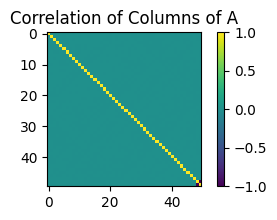

In [55]:
plt.figure(figsize=(4, 2))  # Adjust width and height as needed
plt.imshow(A.T @ A, cmap='viridis')
plt.title("Correlation of Columns of A")
plt.colorbar()  # Adds a color scale for better interpretation
plt.show()

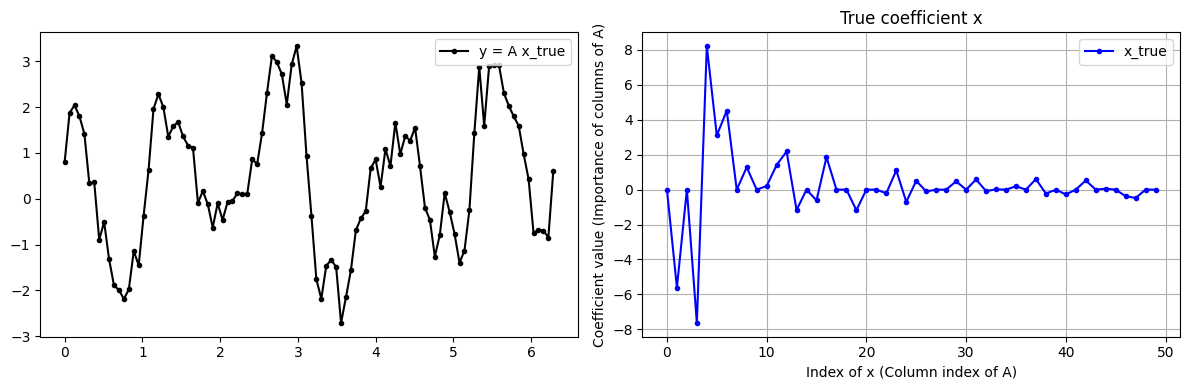

In [56]:
x = np.linspace(0, 2 * np.pi, m)
# columns = np.array([1, 9, 29])
# alpha=0.1

# Create figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot y and selected columns of A
# plot_matrix(A, columns=columns, ax=axes[0])
axes[0].plot(x, b, marker=".", linestyle="-", color="black", label="y = A x_true") 
axes[0].legend()

# Plot x_true and x_lasso with markers only where values > alpha
indices_x_true = np.where(np.abs(x_true.flatten()) > lbd)[0]
# indices_x_lasso = np.where(x_lasso > alpha)[0]
axes[1].plot(x_true, linestyle="-", marker=".", color="blue", label="x_true")
# axes[1].plot(indices_x_true, x_true[indices_x_true], "o", color="blue")  # Add markers only for values > 0.1
# axes[1].plot(x_lasso, linestyle="--", color="red", label="x_lasso (Lasso estimate)")
# axes[1].plot(indices_x_lasso, x_lasso[indices_x_lasso], "o", color="red")  # Add markers only for values > 0.1

# title and labels
axes[1].set_title("True coefficient x")
axes[1].set_xlabel("Index of x (Column index of A)")
axes[1].set_ylabel("Coefficient value (Importance of columns of A)")
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()

# 2. Solving Lasso

In [57]:
lasso = Lasso(A, b, lbd)
ista = ISTA(lasso, Stop(100, 1e-12))
x_lasso = ista.solve()
data = ista.data()


--------------------------New state
Iteration: 1
Gap: 35.314787
Primal: 60.380146
Dual: 25.065360
Active Features: 50
Solution Norm: 3.5853054713196553 Shape: (50,)
Dual Solution Norm: 0.4297379137394993 Shape (100,)
--------------------------New state
Iteration: 2
Gap: 17.219740
Primal: 46.208161
Dual: 28.988421
Active Features: 50
Solution Norm: 5.377958206979483 Shape: (50,)
Dual Solution Norm: 0.585163933958779 Shape (100,)
--------------------------New state
Iteration: 3
Gap: 9.353979
Primal: 42.665164
Dual: 33.311185
Active Features: 50
Solution Norm: 6.274284574809397 Shape: (50,)
Dual Solution Norm: 0.8181085186005382 Shape (100,)
--------------------------New state
Iteration: 4
Gap: 4.875110
Primal: 41.779415
Dual: 36.904306
Active Features: 50
Solution Norm: 6.722447758724354 Shape: (50,)
Dual Solution Norm: 1.0603708866279677 Shape (100,)
--------------------------New state
Iteration: 5
Gap: 2.372001
Primal: 41.557978
Dual: 39.185977
Active Features: 50
Solution Norm: 6.9465

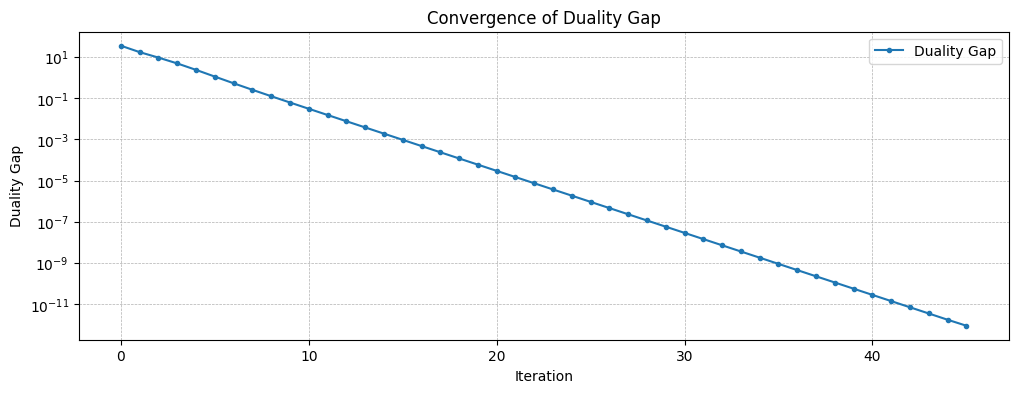

In [58]:
plt.figure(figsize=(12, 4))  # Set figure size
plt.plot(data.gap, marker='.', linestyle='-', label="Duality Gap")  # Add markers and label
plt.yscale("log")  # Use logarithmic scale for better visualization
plt.xlabel("Iteration")  # X-axis label
plt.ylabel("Duality Gap")  # Y-axis label
plt.title("Convergence of Duality Gap")  # Title of the graph
plt.grid(True, which="both", linestyle="--", linewidth=0.5)  # Add grid
plt.legend()  # Show legend
plt.show()


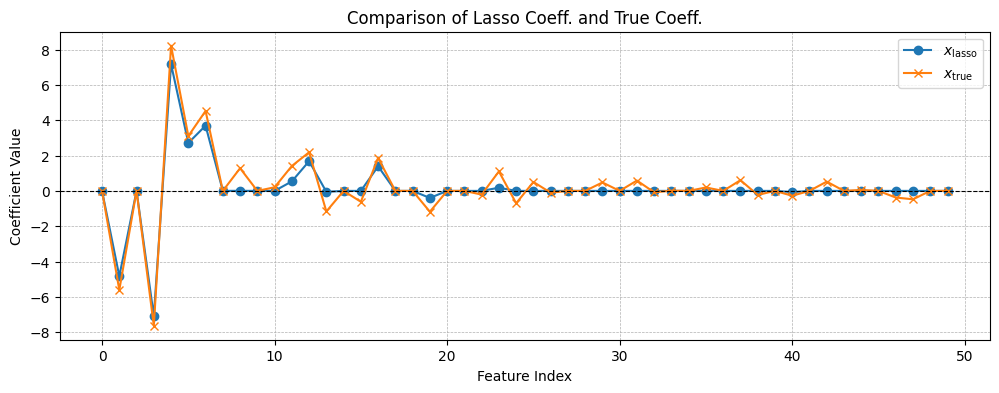

In [59]:
n = len(data.gap)

plt.figure(figsize=(12, 4))  # Set figure size
plt.plot(data.solution[n-1], marker="o", label=r"$x_{\text{lasso}}$")  # Lasso solution
plt.plot(x_true, marker="x", label=r"$x_{\text{true}}$")  # Ground truth solution

plt.xlabel("Feature Index")  # X-axis label
plt.ylabel("Coefficient Value")  # Y-axis label
plt.title("Comparison of Lasso Coeff. and True Coeff.")  # Title of the graph
plt.axhline(0, color='black', linewidth=0.8, linestyle="--")  # Add a horizontal line at y=0
plt.grid(True, linestyle="--", linewidth=0.5)  # Add grid
plt.legend()  # Show legend
plt.show()


# 3. Safe screening

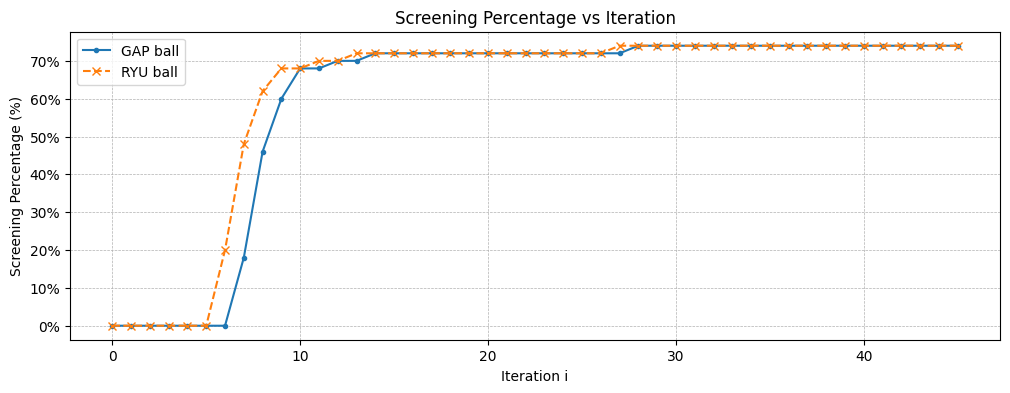

In [60]:
import matplotlib.ticker as mtick

def compute_screening_percentage(lasso: Lasso, data: pd.DataFrame, iteration: int, region: str = "gap") -> float:
    """Computes the screening percentage at a given iteration using the specified region (gap or ryu)."""
    x = data.solution[iteration]  # Get the solution at the given iteration
    active = np.array([True] * len(x))  # Initialize all features as active
    new_active = safe_screening(lasso, active, x, region=region)  # Perform safe screening
    screening_percentage = 1 - new_active.sum() / active.sum()  # Compute percentage
    return screening_percentage

def plot_screening_percentage(lasso: Lasso, data: pd.DataFrame):
    """Plots the screening percentage vs iteration for both GAP ball and RYU ball with y-axis as percentage."""
    iterations = list(range(len(data.solution)))
    
    # Compute screening percentages for both methods
    gap_percentages = [compute_screening_percentage(lasso, data, i, "gap") * 100 for i in iterations]
    ryu_percentages = [compute_screening_percentage(lasso, data, i, "ryu") * 100 for i in iterations]

    plt.figure(figsize=(12, 4))
    plt.plot(iterations, gap_percentages, marker='.', linestyle='-', label="GAP ball")
    plt.plot(iterations, ryu_percentages, marker='x', linestyle='--', label="RYU ball")

    plt.xlabel("Iteration i")
    plt.ylabel(r"Screening Percentage (%)")  # Include percentage symbol
    plt.title("Screening Percentage vs Iteration")
    
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())  # Format y-axis as percentage
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()

    plt.show()

plot_screening_percentage(lasso, data)
